In [5]:
# the goal in this notebook is to use transfer learning on the CIFAR dataset

# import libraries necessary for building the CNN
import numpy as np
import keras
from keras.layers import Input, Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, ZeroPadding2D
from keras.models import Model
from keras.datasets import cifar10
from keras.applications import vgg16

In [2]:
# for plotting the model
# !pip install pydot
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
# important variables
num_classes = 10 # one for each of the digits from 0-9
batch_size = 128 #tunable number
epochs = 13 #tunable number

(32, 32, 3)


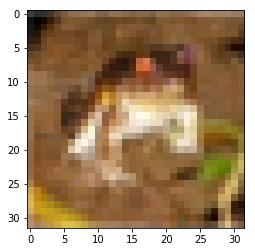

frog


In [4]:
# import cifar10 data from keras
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# I just want to see what these images look like
print(X_train[0].shape)
plt.imshow(X_train[0])
plt.show()


# reshape the x data do it's 4 dimensional --> last number is color channels
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)


# we need to normalize the X data before feeding into our model
X_train = X_train/255 # divide by max value of pixel values to put in range 0 to 1
X_test = X_test/255

# we also need to convert the Y data into one-hot vectors
Y_train = keras.utils.to_categorical(Y_train, num_classes) # may want to explain this more clearly [background]
Y_test = keras.utils.to_categorical(Y_test, num_classes)

# for interpretation purposes, create a dictionary mapping the label numbers
# to image labels
num_to_img = {
    0:"airplane",
    1:"automobile",
    2:"bird",
    3:"cat",
    4:"deer",
    5:"dog",
    6:"frog",
    7:"horse",
    8:"ship",
    9:"truck"
}

print(num_to_img[np.argmax(Y_train[0])])



In [29]:
# pad the normalized input images in order for transfer learning to work
input_shape = [32, 32, 3]
X_input = Input(input_shape)
X = ZeroPadding2D(padding=(8,8))(X_input)

# loading the VGG16 model for transfer learning
my_vgg = vgg16.VGG16(include_top=False, weights='imagenet')

# freezing the transfered layers
#for layer in my_vgg.layers:
    #print(layer.name)
    
# transition conv layer
X = Conv2D(128, kernel_size=(1,1))(X)
X = my_vgg.get_layer("block3_conv1")(X)
#X = my_vgg.get_layer("block3_conv2")(X)
#X = my_vgg.get_layer("block3_pool")(X)
print(X.shape)
#X = Conv2D(16, kernel_size=(1,1))(X)
#X = Activation('relu')(X)

X = Flatten()(X)
X = Dense(num_classes, activation='softmax')(X)

model = Model(inputs=X_input, outputs=X)

(?, 48, 48, 256)


In [30]:
# compile the model
model.compile(loss=keras.losses.categorical_crossentropy, #
             optimizer=keras.optimizers.Adam(), #students can choose optimizers 
             metrics=['accuracy'])

In [33]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 128)       512       
_________________________________________________________________
block3_conv1 (Conv2D)        multiple                  295168    
_________________________________________________________________
flatten_7 (Flatten)          (None, 589824)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5898250   
Total params: 6,193,930
Trainable params: 6,193,930
Non-trainable params: 0
_________________________________________________________________


In [31]:
# train the model on the training data
model.fit(X_train, Y_train, batch_size = batch_size, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/13
  512/50000 [..............................] - ETA: 1:11:17 - loss: 9.8096 - acc: 0.1172

KeyboardInterrupt: 

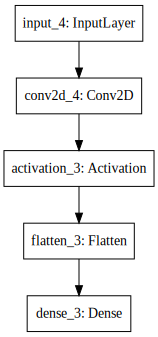

In [50]:
# visualizing model architecture
#import pydot
#plot_model(model, to_file='model01.png')
SVG(model_to_dot(model).create(prog='dot', format="svg"))

In [51]:
# going to visualize the filters of the model  . . . 
# inspiration from here: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# create a dictionary of the model's layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [71]:
from keras import backend as K #the backend in this case is tensorflow, since keras is sitting on top of it
                                #so importing the "backend" will allow us to write code in tensorflow that keras
                                #will be able to use for our model
        
#we'll be sending in an image the size of one of the MNIST images
img_width = 32
img_height = 32
        
layer_name = "conv2d_4"
filter_index = 3 #there are 32 filters, so this could be any number in the range 0-31

# create a loss function that we will use to maximize the activation of the specified layer
layer_output = layer_dict[layer_name].output # accesing the output of the specified layer stored in our dictionary
loss = K.mean(layer_output[:,:,:,filter_index]) # averaging all the outputs of the filter --> remember that the filter
                                                # is a 2-D "square" --> the middle two numbers represent height/width
                                                # of that square, the first number represents batch size, and the 
                                                # final number represents the number of filters (we're accessing a
                                                # specific one here)
# compute the gradient of the input picture with respect to this loss.
# this means we'll be updating the pixels of the input image, not the weights of the network --> clever!
grads = K.gradients(loss, model.input)[0] # I don't know what the [0] means at the end of this line
print(grads)

# normalizing the gradient --> we don't want the magnitude of our gradient ascent/descent step to be infuenced heavily 
# by the gradient --> the gradient gives us the direction we want to take --> so normalizing helps the optimization
# algorithm perform better
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads]) # this is a fancy way of writing a custom function that takes
                                                # an input image as an input, and returns the loss and gradients
                                                # for that image


Tensor("gradients_8/conv2d_4/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 3), dtype=float32)


In [72]:
# running gradient ascent to maximize the activations of the filter

# generating a grey test image
input_img = np.random.random((1, img_width, img_height, 3)) * 20 + 128.

# Choosing an arbitrary value for "step" --> pretty sure this is like the learning rate
step = 5

# 20 steps of gradient ascent
for i in range(50):
    loss_value, grads_value = iterate([input_img])
    input_img += grads_value * step


In [73]:
# creating a function to deprocess the image 
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to black/white representation
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


(32, 32, 3)


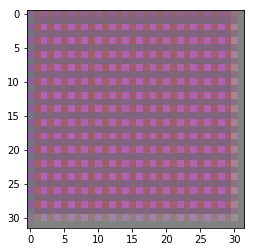

In [74]:
# saving the image as a file
img = input_img
img = deprocess_image(img)

print(img.squeeze().shape)

# the imsave approach
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

# if color channels are first
#img_print = np.swapaxes(img.squeeze(), 0, 2)

# the matplotlib approach
import matplotlib.pyplot as plt
plt.imshow(img.squeeze())
plt.show()

In [ ]:
# upload the custom image and have the network make a prediction on it

# require students to take square images --> for scaling purposes

import cv2

# load the image in greyscale mode
my_img = cv2.imread("./my_img.jpg", 0)
plt.imshow(my_img)
plt.show()

# reshape the custom image
my_img = cv2.resize(my_img, (32,32,3))
plt.imshow(my_img)
plt.show()
